In [2]:
cd ..

/home/janek/reasonable-embeddings


In [3]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm

from src.reasoner_mod import *
from src.simplefact import *
from src.simplefact.syntax import *
from src.generate import *
from src.reasoner import *
from src.utils import *
from src.vis import *

seed = 2022

In [4]:
onto = load_ofn('local/out/dataset/pizza.ofn')
onto.use_annotations_as_names()
onto.use_prefix('pizza:')
fact = Reasoner.from_onto(onto=onto, timeout=None)
    
C = onto.concept_by_name
R = onto.role_by_name
onto

Unsupported class expression ('SubClassOf', 'pizza:American', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:America'))
Unsupported class expression ('SubClassOf', 'pizza:AmericanHot', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:America'))
Unsupported class expression ('EquivalentClasses', 'pizza:Country', ('ObjectIntersectionOf', 'pizza:DomainConcept', ('ObjectOneOf', 'pizza:America', 'pizza:England', 'pizza:France', 'pizza:Germany', 'pizza:Italy')))
Unsupported class expression ('EquivalentClasses', 'pizza:InterestingPizza', ('ObjectIntersectionOf', 'pizza:Pizza', ('ObjectMinCardinality', '3', 'pizza:hasTopping')))
Unsupported class expression ('SubClassOf', 'pizza:MozzarellaTopping', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:Italy'))
Unsupported class expression ('SubClassOf', 'pizza:Napoletana', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:Italy'))
Unsupported class expression ('EquivalentClasses', 'pizza:RealItalianPizza', ('ObjectIntersection

<Onto 99 concepts, 4 roles, 287 axioms>

FaCT++.Kernel: Reasoner for the SROIQ(D) Description Logic, 64-bit
Copyright (C) Dmitry Tsarkov, 2002-2017. Version 1.7.0-SNAPSHOT (01 January 2017)


In [5]:
queries, answers, qset = [], [], set()
concepts = list(range(onto.n_concepts)) + [TOP, BOT]

for c in concepts:
    for d in concepts:
        append_unique((SUB, c, d), queries, qset)

for query in queries:
    answers.append(float(fact.check_axiom(query)))

rng = np.random.default_rng(seed)
queries, answers = jointshuffle(rng, queries, answers)

print(len(answers))
print(np.mean(answers))

10201
0.09459856876776787


In [6]:
X_te = [core(x) for x in queries]
y_te = answers
idx_te = [0]*len(X_te)
data = idx_te, X_te, y_te

rng = np.random.default_rng(seed)
T.manual_seed(seed)
reasoner = ModifiedNeuralReasoner(emb_size=10, hidden_size=16, onto=onto)
print('head params', paramcount(reasoner.head))
print('embs params', paramcount(reasoner.embs))

log = train_mod(data, None, reasoner.head, [reasoner.embs], freeze_reasoner=False,
            epoch_count=20, batch_size=32, lr_reasoner=0.002, lr_encoder=0.002)

head params 3283
embs params 1430
train epoch 00/20 | batch 320/319 | loss 0.7435 | val loss 0.7435 | acc 0.0946 | f1 0.1728 | prec 0.0946 | recall 1.0000 | roc auc 0.5109 | pr auc 0.1130 | elapsed 2.55s
train epoch 01/20 | batch 320/319 | loss 0.2710 | val loss 0.1280 | acc 0.9614 | f1 0.7580 | prec 0.9306 | recall 0.6394 | roc auc 0.9292 | pr auc 0.8303 | elapsed 4.08s
train epoch 02/20 | batch 320/319 | loss 0.1281 | val loss 0.1191 | acc 0.9624 | f1 0.7673 | prec 0.9241 | recall 0.6560 | roc auc 0.9433 | pr auc 0.8463 | elapsed 4.02s
train epoch 03/20 | batch 320/319 | loss 0.1235 | val loss 0.1166 | acc 0.9625 | f1 0.7711 | prec 0.9110 | recall 0.6684 | roc auc 0.9480 | pr auc 0.8511 | elapsed 4.24s
train epoch 04/20 | batch 320/319 | loss 0.1208 | val loss 0.1145 | acc 0.9621 | f1 0.7749 | prec 0.8833 | recall 0.6902 | roc auc 0.9509 | pr auc 0.8551 | elapsed 4.41s
train epoch 05/20 | batch 320/319 | loss 0.1175 | val loss 0.1097 | acc 0.9638 | f1 0.7843 | prec 0.8995 | recall 0.

In [7]:
not_nn = reasoner.head.not_nn
top = reasoner.head.top_concept[0]
bot = reasoner.head.bot_concept[0]
optimizer = T.optim.AdamW(not_nn.parameters(), 0.0001)

for i in range(30000):
    optimizer.zero_grad()
    input1 = T.rand(10)

    loss = (F.mse_loss(input1, not_nn(not_nn(input1))))
    loss+=(F.mse_loss(top, not_nn(bot)))
    loss+=(F.mse_loss(bot, not_nn(top)))

    if i%5000==0:
        print("loss: ", loss)
    loss.backward()
    optimizer.step()

reasoner.head.not_nn = not_nn


and_nn = reasoner.head.and_nn
bot = reasoner.head.bot_concept[0]
top = reasoner.head.top_concept[0]
not_nn = reasoner.head.not_nn
optimizer = T.optim.AdamW(and_nn.parameters(), 0.0001)

for i in range(50000):
    optimizer.zero_grad()
    input1 = T.rand(10)
    input2 = T.rand(10)
    input3 = T.rand(10)
    loss = F.mse_loss(input1, and_nn(im_mod(input1, input1)))
    loss += F.mse_loss(bot, and_nn(im_mod(bot, input1)))
    loss += F.mse_loss(input3, and_nn(im_mod(input3,top)))
    loss += F.mse_loss(bot, and_nn(im_mod(input2, not_nn(input2))))

    if i%10000==0:
        print("loss: ", loss)
    loss.backward()
    optimizer.step()

reasoner.head.and_nn = and_nn

loss:  tensor(1.1540, grad_fn=<AddBackward0>)
loss:  tensor(0.0419, grad_fn=<AddBackward0>)
loss:  tensor(0.0197, grad_fn=<AddBackward0>)
loss:  tensor(0.0070, grad_fn=<AddBackward0>)
loss:  tensor(0.0008, grad_fn=<AddBackward0>)
loss:  tensor(2.5798e-08, grad_fn=<AddBackward0>)
loss:  tensor(1.5492, grad_fn=<AddBackward0>)
loss:  tensor(0.0168, grad_fn=<AddBackward0>)
loss:  tensor(0.0045, grad_fn=<AddBackward0>)
loss:  tensor(0.0070, grad_fn=<AddBackward0>)
loss:  tensor(0.0085, grad_fn=<AddBackward0>)


In [8]:
log = train_mod(data, None, reasoner.head, [reasoner.embs], freeze_reasoner=False,
            epoch_count=10, batch_size=32, lr_reasoner=0.002, lr_encoder=0.002, and_nn_loss_weight=50, not_nn_loss_weight=100, top_bot_weight=18, train_top_bot=True)

train epoch 00/10 | batch 320/319 | loss 0.0103 | val loss 0.0101 | acc 0.9975 | f1 0.9871 | prec 0.9865 | recall 0.9876 | roc auc 0.9999 | pr auc 0.9994 | elapsed 2.56s
train epoch 01/10 | batch 320/319 | loss 0.1296 | val loss 0.0128 | acc 0.9959 | f1 0.9780 | prec 0.9904 | recall 0.9658 | roc auc 0.9998 | pr auc 0.9984 | elapsed 3.97s
train epoch 02/10 | batch 320/319 | loss 0.2196 | val loss 0.0085 | acc 0.9986 | f1 0.9927 | prec 0.9948 | recall 0.9907 | roc auc 0.9999 | pr auc 0.9995 | elapsed 3.95s
train epoch 03/10 | batch 320/319 | loss 0.3184 | val loss 0.0064 | acc 0.9989 | f1 0.9943 | prec 0.9969 | recall 0.9917 | roc auc 1.0000 | pr auc 0.9997 | elapsed 4.08s
train epoch 04/10 | batch 320/319 | loss 0.3233 | val loss 0.0054 | acc 0.9996 | f1 0.9979 | prec 0.9969 | recall 0.9990 | roc auc 1.0000 | pr auc 1.0000 | elapsed 3.89s
train epoch 05/10 | batch 320/319 | loss 0.3304 | val loss 0.0037 | acc 0.9993 | f1 0.9964 | prec 0.9979 | recall 0.9948 | roc auc 1.0000 | pr auc 1.0

             mean  std     micro
acc      0.999902  NaN  0.999902
prec     1.000000  NaN  1.000000
recall   0.998964  NaN  0.998964
f1       0.999482  NaN  0.999482
auc_roc  1.000000  NaN  1.000000
auc_pr   1.000000  NaN  1.000000


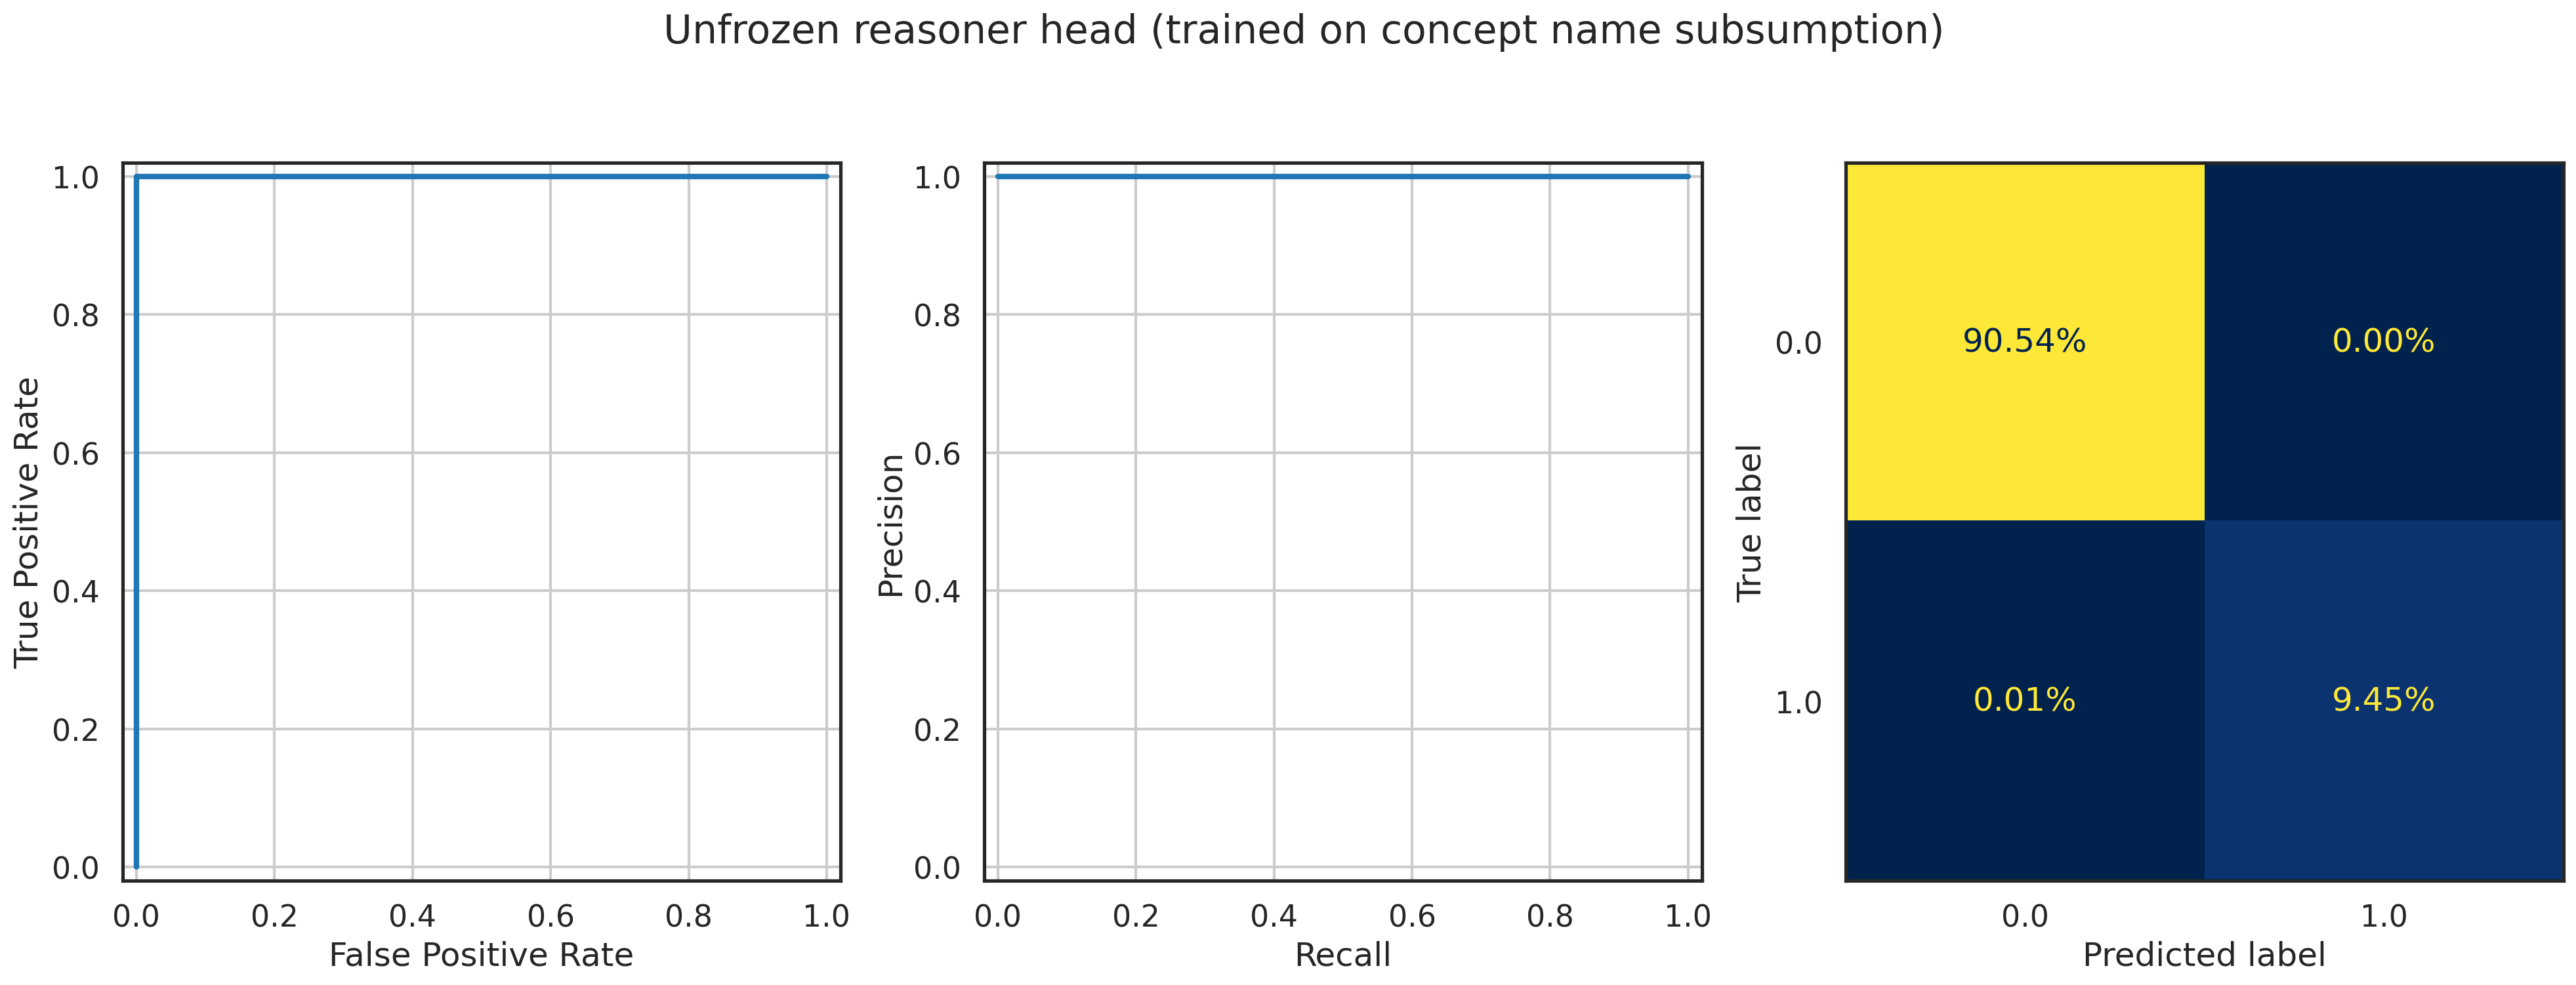

In [9]:
with T.no_grad():
    reasoner.eval()
    _, y_te, Y_te = eval_batch_mod(reasoner.head, [reasoner.embs], X_te, y_te, idx_te)

print(report([onto], y_te, Y_te, idx_te))
plt.suptitle('Unfrozen reasoner head (trained on concept name subsumption)')
plt.show()

AttributeError: 'tuple' object has no attribute 'detach'

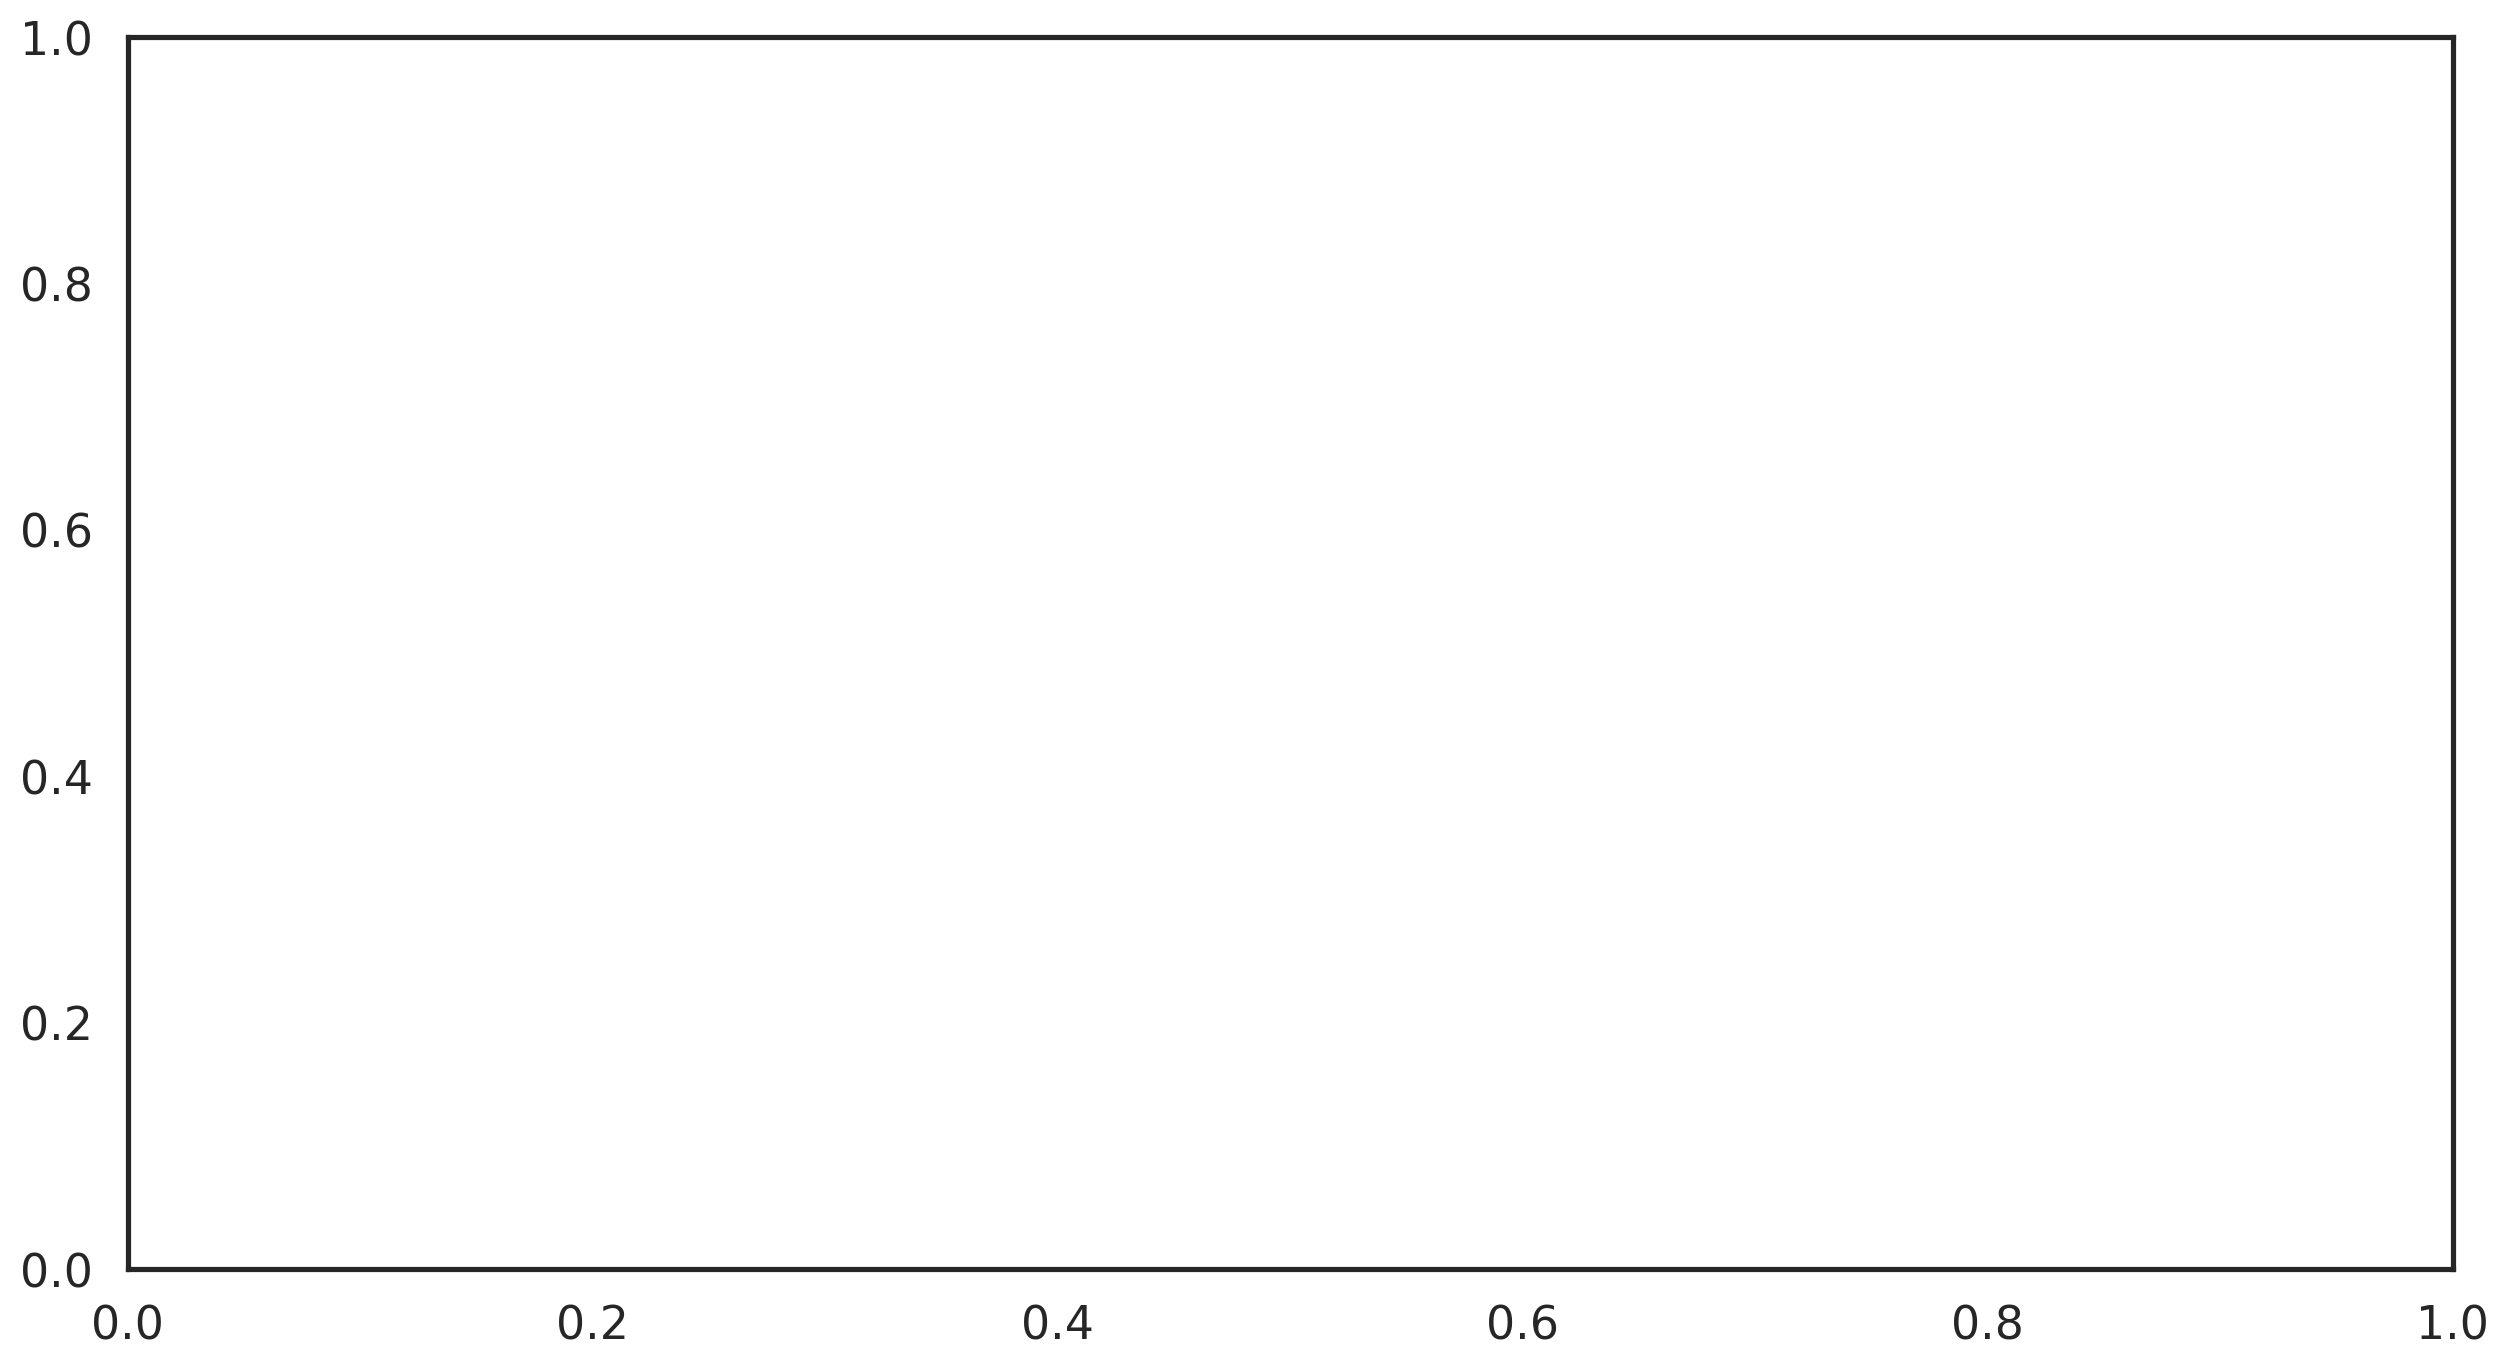

In [10]:
fig, ax = plt.subplots()
vis_pizza(onto, fact, reasoner, min_dist=0.01, ax=ax, reload_pca=True)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [20]:
input = T.rand(10)

print(input)
print(reasoner.head.and_nn(im_mod( input, input)))
F.mse_loss(input, reasoner.head.and_nn(im_mod(input, input)))

tensor([0.3560, 0.7944, 0.1525, 0.8493, 0.5875, 0.4312, 0.5054, 0.1790, 0.3072,
        0.8281])
tensor([0.3383, 0.7533, 0.1384, 0.8012, 0.5327, 0.3855, 0.4732, 0.1409, 0.2890,
        0.7787], grad_fn=<AddBackward0>)


tensor(0.0015, grad_fn=<MseLossBackward0>)

In [27]:
input = T.rand(10)

print(input)
print(reasoner.head.bot_concept[0])
print(reasoner.head.and_nn(im_mod(reasoner.head.bot_concept[0], input)))
print(F.mse_loss(reasoner.head.and_nn(im_mod(reasoner.head.bot_concept[0], input)), reasoner.head.bot_concept[0]))

tensor([0.9225, 0.6162, 0.2974, 0.8972, 0.7537, 0.1218, 0.8146, 0.8204, 0.0408,
        0.2990])
tensor([-1.0309, -0.3720,  0.5582,  0.2859, -0.0899,  0.0461, -0.9944,  0.5799,
         0.7423, -0.8180], grad_fn=<SelectBackward0>)
tensor([-0.8393, -0.2829,  0.5157,  0.2657, -0.0435,  0.0695, -0.8202,  0.4968,
         0.6579, -0.6841], grad_fn=<AddBackward0>)
tensor(0.0112, grad_fn=<MseLossBackward0>)


In [28]:
input = T.rand(10)

print(input)
print(reasoner.head.and_nn(im_mod(reasoner.head.top_concept[0], input)))
print(F.mse_loss(reasoner.head.and_nn(im_mod(reasoner.head.top_concept[0], input)), input))


tensor([0.6738, 0.5278, 0.6281, 0.3449, 0.9808, 0.1793, 0.0963, 0.7290, 0.9842,
        0.0347])
tensor([ 0.0713, -0.4044, -0.3684, -0.4755,  0.3021,  0.0617,  0.5529,  0.5978,
        -0.1860,  0.0066], grad_fn=<AddBackward0>)
tensor(0.4968, grad_fn=<MseLossBackward0>)


In [31]:
input = T.rand(10)

print(reasoner.head.bot_concept[0])
output = reasoner.head.and_nn(im_mod(reasoner.head.not_nn(input), input))
print(output)
print(F.mse_loss(output, input))


tensor([-1.0309, -0.3720,  0.5582,  0.2859, -0.0899,  0.0461, -0.9944,  0.5799,
         0.7423, -0.8180], grad_fn=<SelectBackward0>)
tensor([ 0.0416,  0.2183,  0.0166, -0.3624,  0.8466, -0.2750,  0.2344,  0.1565,
         0.0391, -0.1244], grad_fn=<AddBackward0>)
tensor(0.1842, grad_fn=<MseLossBackward0>)


In [34]:
print(reasoner.head.bot_concept[0])
output = reasoner.head.not_nn(reasoner.head.top_concept[0])
print(output)
print(F.mse_loss(reasoner.head.bot_concept[0], output))

tensor([-1.0309, -0.3720,  0.5582,  0.2859, -0.0899,  0.0461, -0.9944,  0.5799,
         0.7423, -0.8180], grad_fn=<SelectBackward0>)
tensor([-0.6813, -0.3974,  0.3301,  0.2937,  0.1305, -0.0552, -0.8946,  0.6553,
         0.8619, -0.6209], grad_fn=<SqueezeBackward3>)
tensor(0.0303, grad_fn=<MseLossBackward0>)


In [37]:
print(reasoner.head.top_concept[0])
output = reasoner.head.not_nn(reasoner.head.bot_concept[0])
print(output)
print(F.mse_loss(reasoner.head.top_concept[0], output))

tensor([ 0.6646, -0.0611, -0.5896, -0.5788,  0.3829,  0.2431,  1.4468,  0.5705,
        -0.5271,  0.6258], grad_fn=<SelectBackward0>)
tensor([ 0.8190, -0.1507, -0.5509, -0.3847,  0.5084,  0.2644,  1.1755,  0.2840,
        -0.5811,  0.7307], grad_fn=<SqueezeBackward3>)
tensor(0.0257, grad_fn=<MseLossBackward0>)
